Tutorial 1: Generating a mesh using a single DEM data source.
---
### Step 1: Loading a DEM raster data source.

We start by downloading a sample raster file from the NOAA NCEI Continously Updated Digital Elevation Model (CUDEM) database. The raster class can read directly from URL, so we pass that as input to init. Note that opening the raster does not consume significant amounts of RAM memory, since only a pointer to a file is stored, and the data is not loaded to the RAM until it is required by some other operation.

In [1]:
from geomesh import Raster
url = 'https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n41x00_w074x00_2015v1.tif'
raster = Raster(url)

Let's use the built-in `raster.make_plot()` method to have a view of the data we just loaded.

<IPython.core.display.Javascript object>


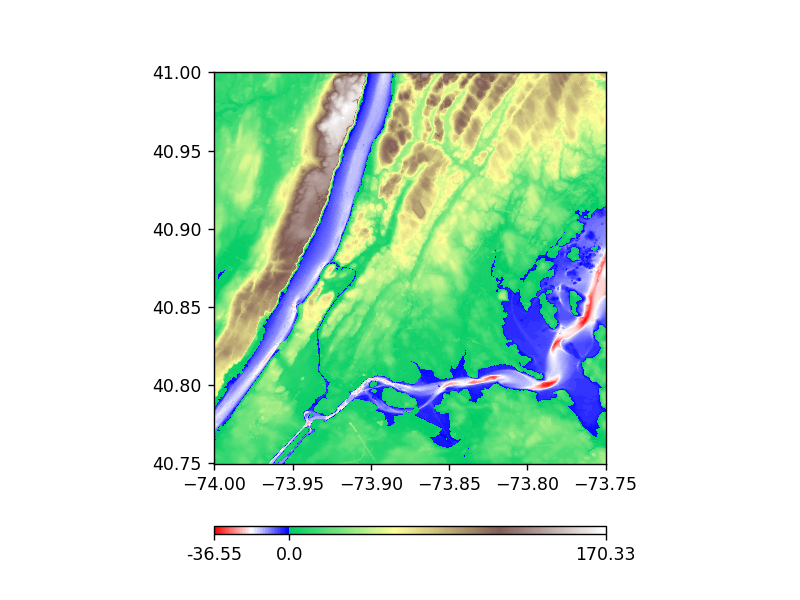

<AxesSubplot:>

In [2]:
%matplotlib notebook
raster.make_plot(show=True)

Let's zoom-in into the narrowest segment of the Harlem River. This narrow passage measures around 100 meters across, which implies that the minimum resolution to capture this feature has to be smaller than half this distance. In practice, using 30 meters of resolution in this area tends to capture this feature sufficiently well.

<IPython.core.display.Javascript object>


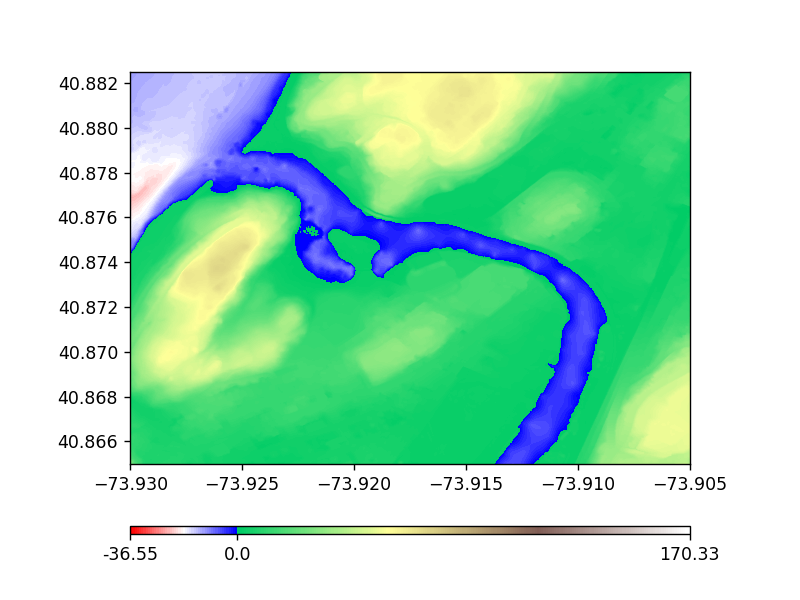

In [3]:
import matplotlib.pyplot as plt
ax = raster.make_plot()
zoom_view = [-73.930, -73.905, 40.8650, 40.8825]
ax.axis(zoom_view)
plt.show()

Note: Running the `make_plot()` method will load the raster's array data (first band) to the RAM. Once the data has been consumed, the data is unloaded from the RAM, making sure the computer's available memory doesn't run out, and preventing associated out-of-memory crashes.

###  Step 2: Generating input `geom` from the raster.
In mesh generation lingo, a `geom` is an object that defines the topological boundaries of the output mesh. In simple terms, a "geom" is a polygon or multipolygon as described by the [OpenGIS standards](https://www.ogc.org/standards/sfa). Internally, this `geom`/`polygon` is type-casted into a `jigsaw_msh_t` instance.

Geomesh provides a `Geom` class, which can be used to generate these objects from multiple objects.

One of the important features is the initiliazation signature, is that it can take optional `zmin` and `zmax` parameters, which are used to control to upper and lower bounds of the resulting `geom`.

<IPython.core.display.Javascript object>


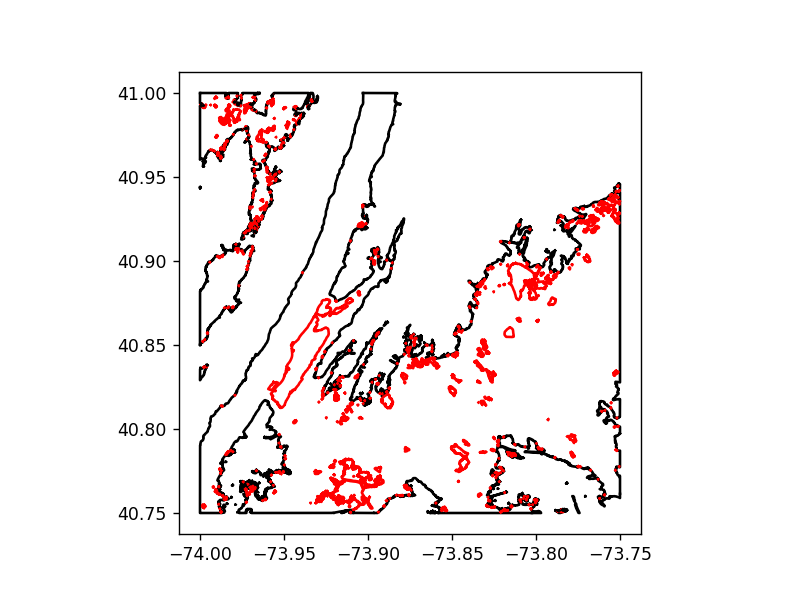

<AxesSubplot:>

In [4]:
from geomesh import Geom
geom = Geom(raster, zmax=15.)
geom.make_plot(show=True)

The output figure above shows the computed `geom`, which corresponds to a `multipolygon`. On the figure, the black lines are the exterior rings of each polygon, while the red lines are the interior rings (holes) of the polygon. The areas bounded by the polygon's interior represent those values that satisfy the `zmin` and `zmax` user requirements.

### Step 3: Generating a size function.
In step 2, we generated the topological boundaries of our mesh, now we need to generate an appropriate size function. Since the Harlem River measures roughly 100 meters at its shortest cross-section, by the Nyquist theorem, we know we need at least half of that distance to be able to resolve the feature. In practice, 30 meters seems to do the trick. We now develop the size function for this tile via the `Hfun` class.

<IPython.core.display.Javascript object>


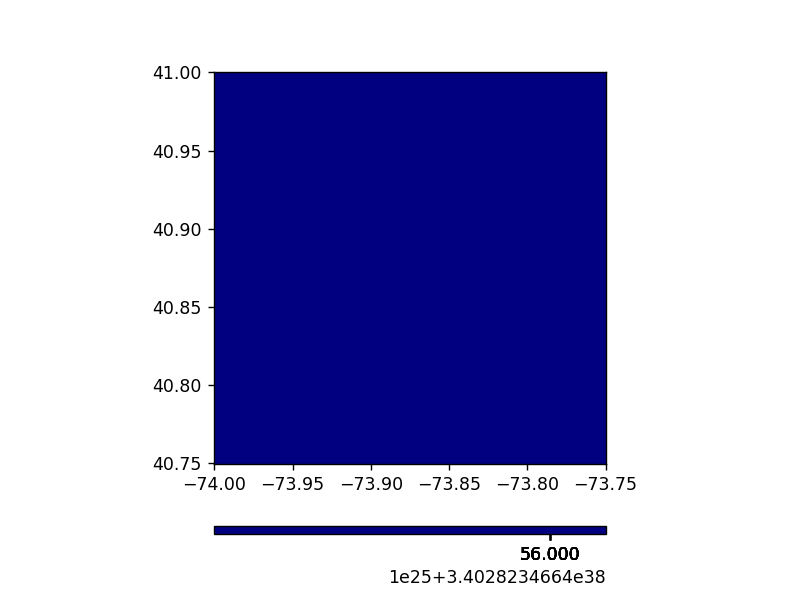

<AxesSubplot:>

In [5]:
from geomesh import Hfun
hfun = Hfun(raster)
hfun.make_plot(show=True)

The plot above is not very interesting. It show that the default element size is a very large constant value (`~3.4028235e+38` or more precisely `np.finfo(np.float32).max`), therefore an `Hfun` instance without constraints is not very useful.

We now add constraints to the size function. We will use the `add_gradient_delimiter` method to make sure we have a good tesselation of small features. We will also constraint this gradient limiter to only a certain depth range, and we will also constraint the minumum and maximum allowable element sizes via the `zmin` and `zmax` arguments respectively.

<IPython.core.display.Javascript object>


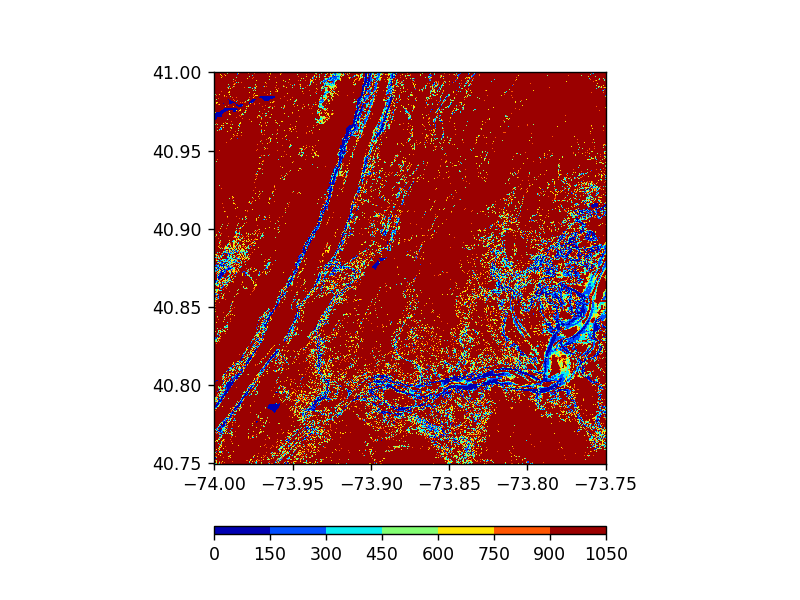

<AxesSubplot:>

In [6]:
hfun.add_gradient_delimiter(hmin=30., hmax=1000.)
hfun.make_plot(show=True)

The size function now shows that areas with high gradients, such as the Harlem River Channel are now better delineated. The element sizes in areas of high gradients will approach the `hmin` value, while areas of lower gradients will approach the `hmax` value.


The `make_plot` method above plots the `raster` array, this is not yet the mesh! Let's now take a look at how the mesh option above translate into an unstructured mesh. By calling the `triplot` method, which we can plot a "preliminary" view of the unstructured mesh, which is generated by calling the `JIGSAW` engine.

<IPython.core.display.Javascript object>


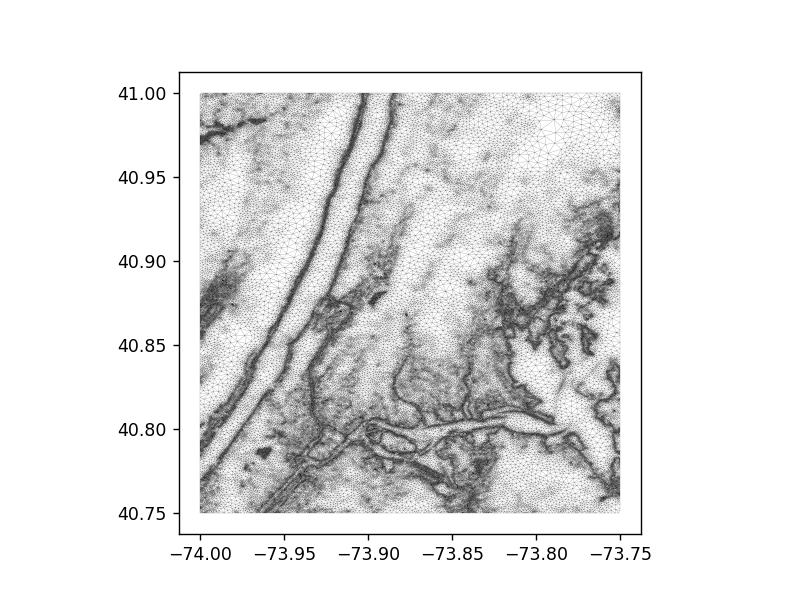

<AxesSubplot:>

In [7]:
hfun.triplot(show=True)

We can also use the `tricontourf` method to plot a view that includes the size function values interpolated to the mesh.

<IPython.core.display.Javascript object>


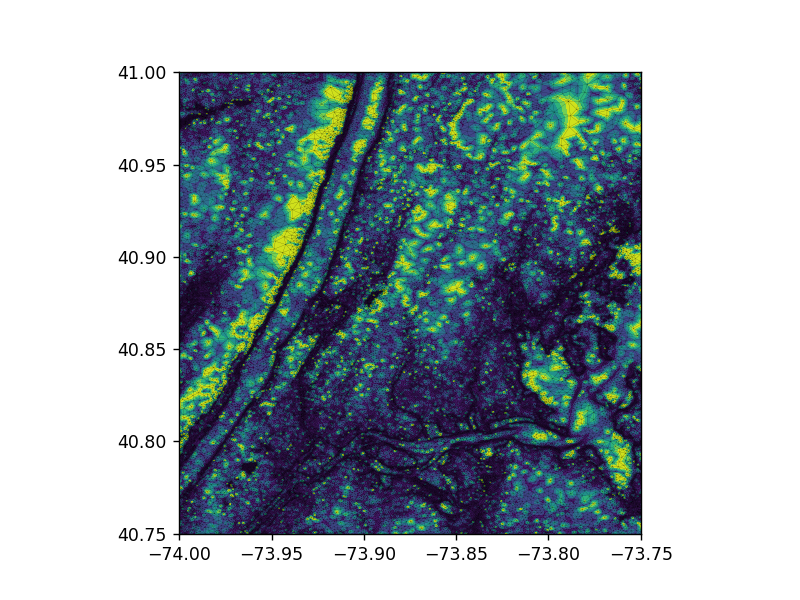

<AxesSubplot:>

In [8]:
hfun.tricontourf(show=True)

We have a good tesselation, but let's explore the effect of a different constraint. We will reload the raster into a new `hfun` instance, and we will try adding a contour at level=0.

In [9]:
hfun = Hfun(raster)
hfun.add_contour(level=0, target_size=30., expansion_rate=0.01)

<IPython.core.display.Javascript object>


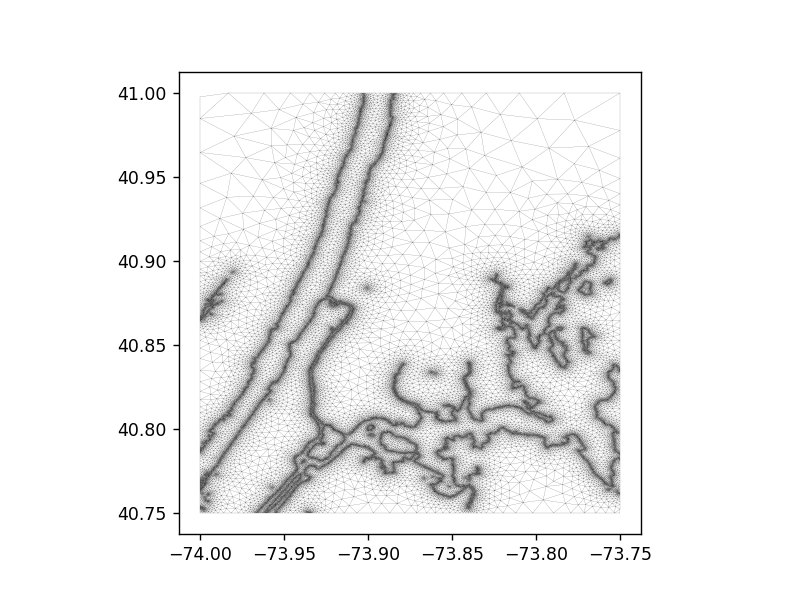

<AxesSubplot:>

In [10]:
hfun.triplot(show=True)

<IPython.core.display.Javascript object>


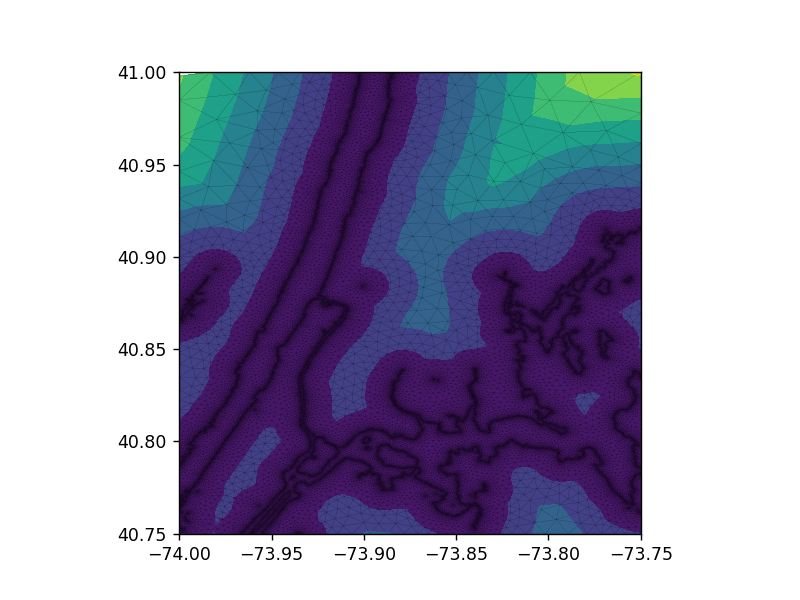

<AxesSubplot:>

In [11]:
hfun.tricontourf(show=True)

Additionally, the constraints can be compounded. Let's add the gradient delimiter option, but only within a range of elevation values.

In [12]:
hfun.add_gradient_delimiter(hmin=30., hmax=100., lower_bound=-3., upper_bound=1.0)
hfun.add_constant_value(250., lower_bound=0.)

<IPython.core.display.Javascript object>


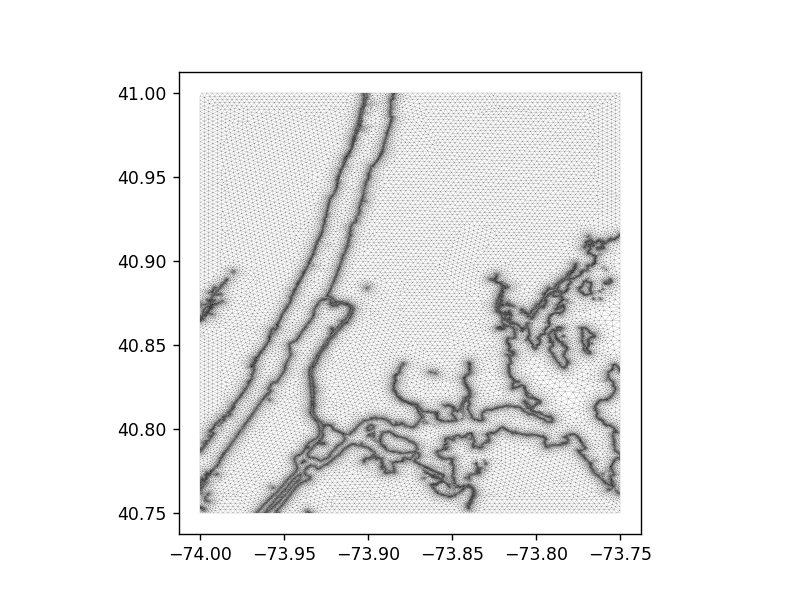

<AxesSubplot:>

In [13]:
hfun.triplot(show=True)

### Step 4: Combining Geom and Hfun into final mesh.
Our final step is to combine the hfun and geom classes, and optimize the mesh.

<IPython.core.display.Javascript object>


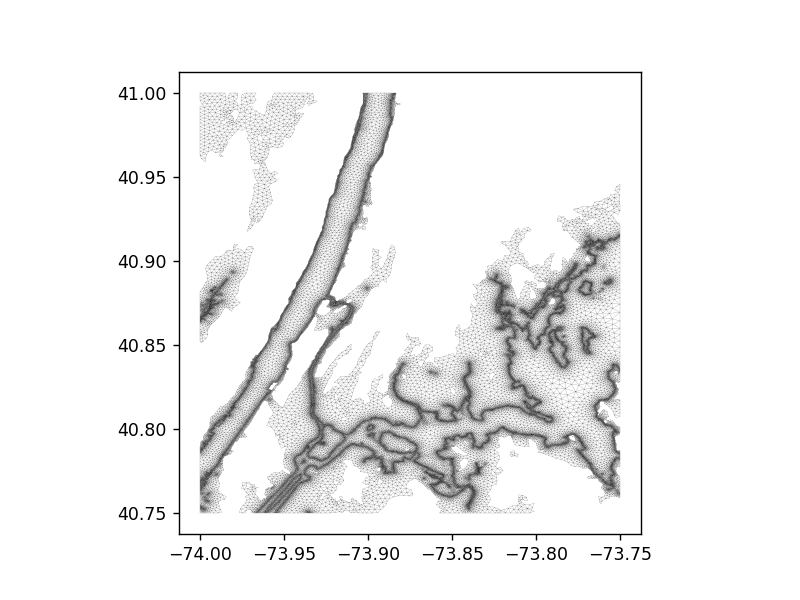

<AxesSubplot:>

In [14]:
from geomesh import JigsawDriver
driver = JigsawDriver(geom=geom, hfun=hfun)
mesh = driver.run()
mesh.triplot(show=True)

### Step 5: Interpolating a raster to the mesh.

<IPython.core.display.Javascript object>


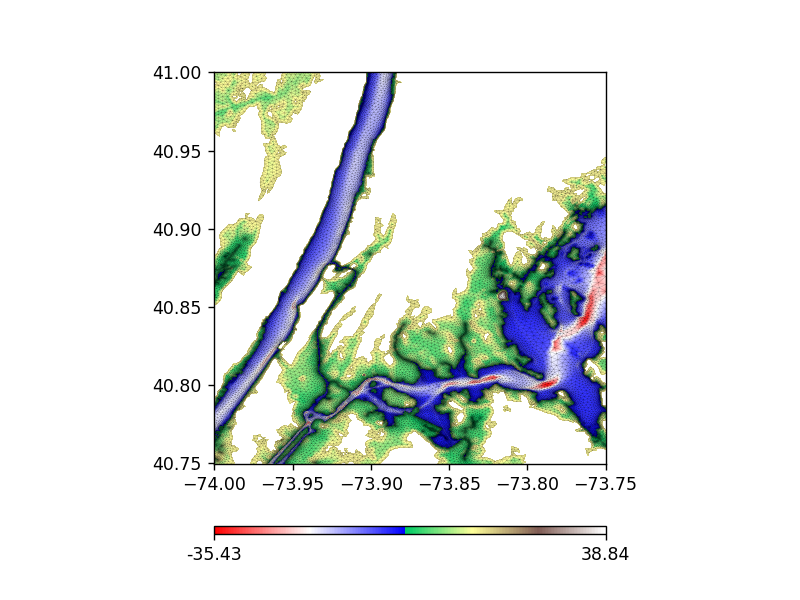

<AxesSubplot:>

In [15]:
mesh.interpolate(raster)
mesh.make_plot(show=True, elements=True)

And zooming in again into the Harlem River bend, we notice that there are suffient elements to capture the feature well.

<IPython.core.display.Javascript object>


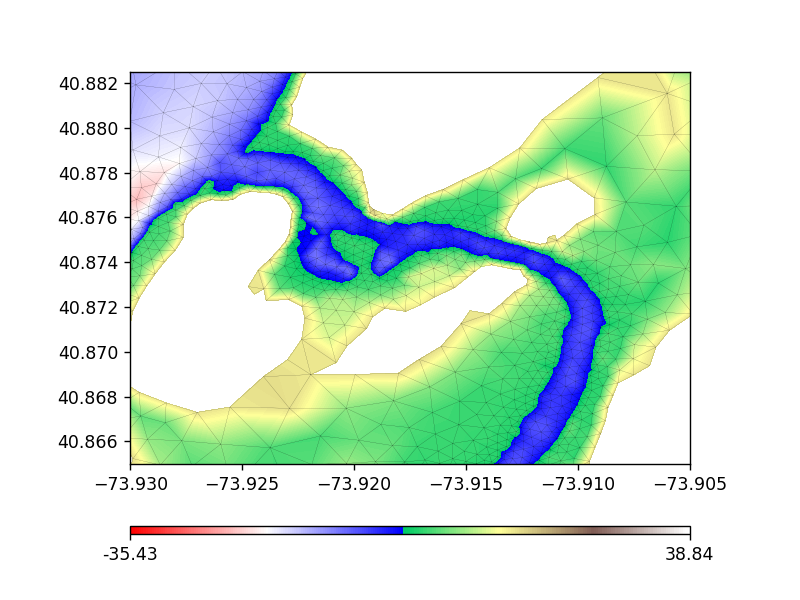

In [16]:
ax = mesh.make_plot(show=True, elements=True)
ax.axis(zoom_view)
plt.show()